In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond
# 
# In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df
# 
# For more reinforcment learning tutorials, see:
# https://github.com/awjuliani/DeepRL-Agents

# In[1]:


from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
#get_ipython().run_line_magic('matplotlib', 'inline')


# ### Load the game environment

# Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

# In[2]:




/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/s

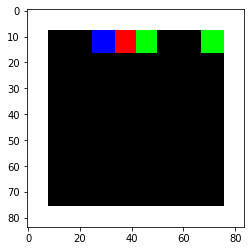

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=8)

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def processState(states):
    return np.reshape(states,[21168])

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
Use keras.layers.flatten instead.


Saved Model
500 -0.6 1
1000 0.2 1
1500 0.4 1
2000 -0.2 1
2500 0.1 1
3000 -0.4 1
3500 -0.2 1
4000 -0.1 1
4500 -0.7 1
5000 0.9 1
5500 -0.4 1
6000 -0.1 1
6500 0.1 1
7000 0.3 1
7500 -0.9 1
8000 0.4 1
8500 -0.2 1
9000 0.2 1
9500 0.0 1
10000 0.1 1
10500 -0.4 0.9549999999999828
11000 -0.1 0.9099999999999655
11500 -0.6 0.8649999999999483
12000 -0.2 0.819999999999931
12500 0.0 0.7749999999999138
13000 0.4 0.7299999999998965
13500 -0.6 0.6849999999998793
14000 -0.4 0.639999999999862
14500 0.0 0.5949999999998448
15000 0.1 0.5499999999998275
15500 1.2 0.5049999999998103
16000 -0.4 0.4599999999998177
16500 0.3 0.41499999999982823
17000 0.5 0.36999999999983874
17500 -0.3 0.32499999999984924
18000 0.6 0.27999999999985975
18500 -0.1 0.23499999999986562
19000 0.4 0.18999999999986225
19500 0.1 0.14499999999985888
20000 -0.1 0.09999999999985551
20500 0.4 0.09999999999985551
21000 0.4 0.09999999999985551
21500 0.1 0.09999999999985551
22000 0.1 0.09999999999985551
22500 0.5 0.09999999999985551
23000 -0.1 0

84000 1.3 0.09999999999985551
84500 4.8 0.09999999999985551
85000 3.5 0.09999999999985551
85500 3.1 0.09999999999985551
86000 4.8 0.09999999999985551
86500 3.2 0.09999999999985551
87000 3.1 0.09999999999985551
87500 3.0 0.09999999999985551
88000 3.0 0.09999999999985551
88500 5.2 0.09999999999985551
89000 6.3 0.09999999999985551
89500 3.2 0.09999999999985551
90000 3.7 0.09999999999985551
90500 5.0 0.09999999999985551
91000 6.5 0.09999999999985551
91500 3.5 0.09999999999985551
92000 6.3 0.09999999999985551
92500 4.1 0.09999999999985551
93000 4.7 0.09999999999985551
93500 5.2 0.09999999999985551
94000 6.2 0.09999999999985551
94500 5.8 0.09999999999985551
95000 4.5 0.09999999999985551
95500 4.7 0.09999999999985551
96000 3.3 0.09999999999985551
96500 4.3 0.09999999999985551
97000 6.0 0.09999999999985551
97500 6.4 0.09999999999985551
98000 5.1 0.09999999999985551
98500 4.5 0.09999999999985551
99000 5.3 0.09999999999985551
99500 5.2 0.09999999999985551
100000 7.2 0.09999999999985551
Saved Mod

216500 6.5 0.09999999999985551
217000 7.4 0.09999999999985551
217500 7.3 0.09999999999985551
218000 6.5 0.09999999999985551
218500 8.2 0.09999999999985551
219000 10.8 0.09999999999985551
219500 7.8 0.09999999999985551
220000 7.1 0.09999999999985551
220500 5.4 0.09999999999985551
221000 7.6 0.09999999999985551
221500 7.6 0.09999999999985551
222000 5.1 0.09999999999985551
222500 7.1 0.09999999999985551
223000 6.9 0.09999999999985551
223500 7.8 0.09999999999985551
224000 9.2 0.09999999999985551
224500 6.6 0.09999999999985551
225000 7.6 0.09999999999985551
225500 7.0 0.09999999999985551
226000 6.5 0.09999999999985551
226500 5.9 0.09999999999985551
227000 8.0 0.09999999999985551
227500 6.4 0.09999999999985551
228000 7.4 0.09999999999985551
228500 10.0 0.09999999999985551
229000 6.8 0.09999999999985551
229500 8.2 0.09999999999985551
230000 7.5 0.09999999999985551
230500 6.5 0.09999999999985551
231000 6.5 0.09999999999985551
231500 7.8 0.09999999999985551
232000 7.6 0.09999999999985551
232500

343000 10.2 0.09999999999985551
343500 6.8 0.09999999999985551
344000 7.2 0.09999999999985551
344500 7.5 0.09999999999985551
345000 9.9 0.09999999999985551
345500 7.1 0.09999999999985551
346000 7.8 0.09999999999985551
346500 8.1 0.09999999999985551
347000 9.2 0.09999999999985551
347500 10.8 0.09999999999985551
348000 9.3 0.09999999999985551
348500 9.7 0.09999999999985551
349000 8.9 0.09999999999985551
349500 8.7 0.09999999999985551
350000 6.1 0.09999999999985551
Saved Model
350500 7.9 0.09999999999985551
351000 9.5 0.09999999999985551
351500 8.8 0.09999999999985551
352000 7.6 0.09999999999985551
352500 8.6 0.09999999999985551
353000 7.8 0.09999999999985551
353500 8.5 0.09999999999985551
354000 6.6 0.09999999999985551
354500 8.9 0.09999999999985551
355000 7.6 0.09999999999985551
355500 8.4 0.09999999999985551
356000 9.4 0.09999999999985551
356500 8.0 0.09999999999985551
357000 8.2 0.09999999999985551
357500 5.9 0.09999999999985551
358000 7.4 0.09999999999985551
358500 10.0 0.09999999999

474500 9.5 0.09999999999985551
475000 7.4 0.09999999999985551
475500 7.5 0.09999999999985551
476000 9.5 0.09999999999985551
476500 8.9 0.09999999999985551
477000 10.1 0.09999999999985551
477500 6.1 0.09999999999985551
478000 4.5 0.09999999999985551
478500 7.9 0.09999999999985551
479000 9.7 0.09999999999985551
479500 7.4 0.09999999999985551
480000 11.2 0.09999999999985551
480500 9.8 0.09999999999985551
481000 10.0 0.09999999999985551
481500 10.5 0.09999999999985551
482000 6.8 0.09999999999985551
482500 8.5 0.09999999999985551
483000 7.4 0.09999999999985551
483500 7.8 0.09999999999985551
484000 8.4 0.09999999999985551
484500 8.9 0.09999999999985551
485000 7.9 0.09999999999985551
485500 10.9 0.09999999999985551
486000 8.7 0.09999999999985551
486500 7.9 0.09999999999985551
487000 9.8 0.09999999999985551
487500 9.4 0.09999999999985551
488000 10.7 0.09999999999985551
488500 7.3 0.09999999999985551
489000 8.0 0.09999999999985551
489500 9.4 0.09999999999985551
490000 8.4 0.09999999999985551
49

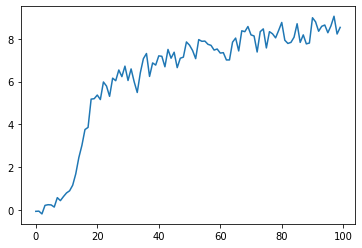

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)